# Small Nimm 6 tournament

In [1]:
import numpy as np
import logging
import sys
import torch
import pickle
from tqdm import tqdm
from matplotlib import pyplot as plt

sys.path.append("../")

from rl_6_nimmt import Tournament, GameSession
from rl_6_nimmt.agents import Human, DrunkHamster, BatchedACERAgent, Noisy_D3QN_PRB_NStep, MCSAgent, PolicyMCSAgent

logging.basicConfig(format="%(message)s",level=logging.INFO)
for name in logging.root.manager.loggerDict:
    if not "rl_6_nimmt" in name:
        logging.getLogger(name).setLevel(logging.WARNING)


## Agents

In [2]:
agents = {}
    
agents[f"DQN"] = Noisy_D3QN_PRB_NStep(history_length=int(1e5), n_steps=10)
agents[f"ACER"] = BatchedACERAgent(minibatch=10)
agents[f"MCS"] = MCSAgent(mc_max=400)
agents[f"AlphaAlmostZero"] = PolicyMCSAgent(mc_max=400)
agents[f"Random"] = DrunkHamster()

for agent in agents.values():
    try:
        agent.train()
    except:
        pass
    
baseline_agents = [DrunkHamster()]

merle = Human("Merle")


In [ ]:
tournament = Tournament(min_players=2, max_players=2, baseline_agents=baseline_agents)

for name, agent in agents.items():
    tournament.add_player(name, agent)

print(tournament)

## Load existing state (skip when running this for the first time)

In [4]:
agents, tournament = pickle.load(open("./.tournament.pickle", "rb"))

print(tournament)

Tournament after 6065 games:
----------------------------------------------------------------------------------------------------
 Agent                | Games | Tournament score | Tournament wins | Baseline score | Baseline wins 
----------------------------------------------------------------------------------------------------
                  DQN |  2418 |            -8.60 |            0.36 |          -7.67 |          0.52 
                 ACER |  2419 |            -8.53 |            0.35 |          -7.12 |          0.62 
                  MCS |  2378 |            -4.55 |            0.72 |          -3.92 |          0.81 
      AlphaAlmostZero |  2451 |            -4.59 |            0.72 |          -3.98 |          0.80 
               Random |  2464 |            -8.76 |            0.36 |          -8.16 |          0.50 
----------------------------------------------------------------------------------------------------


## Let the games begin

In [ ]:
num_games = 20000
block_len = 1000

try:
    tqdm._instances.clear()  # Important after cancelling any step
except:
    pass

while tournament.total_games < num_games:
    for _ in tqdm(range(block_len)):
        tournament.play_game()
    print(tournament)


In [99]:
pickle.dump((agents, tournament), open( "./.tournament.pickle", "wb" ))

## Let's see the results

In [100]:
print(tournament)

Tournament after 6065 games:
----------------------------------------------------------------------------------------------------
 Agent                | Games | Tournament score | Tournament wins | Baseline score | Baseline wins 
----------------------------------------------------------------------------------------------------
                  DQN |  2418 |            -8.60 |            0.36 |          -7.67 |          0.52 
                 ACER |  2419 |            -8.53 |            0.35 |          -7.12 |          0.62 
                  MCS |  2378 |            -4.55 |            0.72 |          -3.92 |          0.81 
      AlphaAlmostZero |  2451 |            -4.59 |            0.72 |          -3.98 |          0.80 
               Random |  2464 |            -8.76 |            0.36 |          -8.16 |          0.50 
----------------------------------------------------------------------------------------------------


In [101]:
def plot_running_mean(x, y, n=10, **kwargs):
    cumsum = np.cumsum(np.insert(y, 0, 0))
    running_mean_y = (cumsum[n:] - cumsum[:-n]) / n
    
    cumsum = np.cumsum(np.insert(x, 0, 0))
    running_mean_x = (cumsum[n:] - cumsum[:-n]) / n
    
    plt.plot(running_mean_x, running_mean_y, **kwargs)


In [102]:
labels = [
    "Mean Hornochsen in tournament",
    "Mean Hornochsen vs baseline",
    "Win fraction in tournament",
    "Win fraction vs baseline"
]
quantities = [
    tournament.tournament_scores,
    tournament.baseline_scores,
    tournament.tournament_wins,
    tournament.baseline_wins
]
fns = [lambda x : -x, lambda x : -x, lambda x : x, lambda x : x]
baselines = [False, True, False, True]

colors = {
    "DQN": "C0",
    "ACER": "C1",
    "MCS": "C2",
    "AlphaAlmostZero": "C3",
    "Random": "0.6",
}
lss = {
    "DQN": "-",
    "ACER": "-",
    "MCS": "-",
    "AlphaAlmostZero": "-",
    "Random": "-",
}

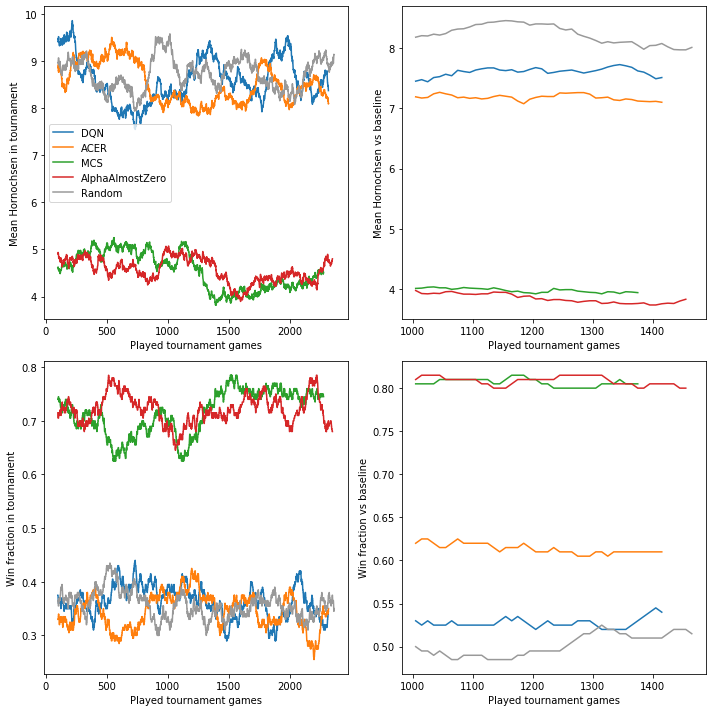

In [103]:
fig = plt.figure(figsize=(10,10))

for panel, (quantity, label, fn, baseline) in enumerate(zip(quantities, labels, fns, baselines)):
    ax = plt.subplot(2,2,panel + 1)
    
    for name in tournament.agents.keys():
        y = np.array(quantity[name])
        x = 10 * np.arange(1, len(y) + 1) if baseline else np.arange(1, len(y) + 1)
        plot_running_mean(x, fn(y), n=200, label=name, color=colors[name], ls=lss[name], lw=1.5)
    
    if panel == 0:
        plt.legend(loc="center left")
        
    plt.xlabel("Played tournament games")
    plt.ylabel(label)

plt.tight_layout()
plt.savefig("tournament_results.pdf")


## Winner vs Merle

In [7]:
opponent = agents["AlphaAlmostZero"]
opponent.mc_max = 1000

session = GameSession(merle, opponent)

# The DEBUG output shows the moves, which is nice
for name in logging.root.manager.loggerDict:
    if "rl_6_nimmt" in name:
        logging.getLogger(name).setLevel(logging.DEBUG)
        

In [ ]:
session.play_game(render=True)

Dealing cards
------------------------------------------------------------------------------------------------------------------------
Board:
   22+   _    _    _    _    * 
   92    _    _    _    _    * 
  102    _    _    _    _    * 
   97    _    _    _    _    * 
Players:
  Merle           (player 1):   0 Hornochsen, cards   7   25.  33+  37   42   64   68   73   79   83 
  AlphaAlmostZero (player 2):   0 Hornochsen, cards   3   24   28   36   52   54   75.  77+  90:  91 
------------------------------------------------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:   7  25  33  37  42  64  68  73  79  83. Choose one to play! 25


AlphaAlmostZero thoughts:
      3: p = 0.09, n =  99, E[r] =  -7.8
     24: p = 0.09, n =  82, E[r] =  -8.0
     28: p = 0.09, n =  74, E[r] =  -8.7
     36: p = 0.08, n =  75, E[r] =  -8.4
     52: p = 0.09, n =  84, E[r] =  -8.7
     54: p = 0.09, n =  92, E[r] =  -8.4
     75: p = 0.11, n = 122, E[r] =  -8.1
     77: p = 0.11, n = 120, E[r] =  -7.2
  x  90: p = 0.13, n = 127, E[r] =  -6.4
     91: p = 0.13, n = 125, E[r] =  -7.5
Merle           (player 1) plays card 25
AlphaAlmostZero (player 2) plays card 90
------------------------------------------------------------------------------------------------------------------------
Board:
   22+  25.  90:   _    _    * 
   92    _    _    _    _    * 
  102    _    _    _    _    * 
   97    _    _    _    _    * 
Players:
  Merle           (player 1):   0 Hornochsen, cards   7   33+  37   42   64   68   73   79   83 
  AlphaAlmostZero (player 2):   0 Hornochsen, cards   3   24   28   36   52   54   75.  77+  91 
-----------------------

It is your turn, Merle! You have the following cards:   7  33  37  42  64  68  73  79  83. Choose one to play! 33


AlphaAlmostZero thoughts:
      3: p = 0.13, n = 133, E[r] =  -6.5
     24: p = 0.10, n = 113, E[r] =  -6.5
     28: p = 0.10, n =  89, E[r] =  -6.2
     36: p = 0.09, n =  96, E[r] =  -7.0
     52: p = 0.10, n = 102, E[r] =  -6.5
     54: p = 0.10, n = 106, E[r] =  -6.5
  x  75: p = 0.12, n = 121, E[r] =  -5.7
     77: p = 0.12, n = 116, E[r] =  -6.9
     91: p = 0.13, n = 124, E[r] =  -6.1
Merle           (player 1) plays card 33
  ...chooses to replace row 2
  ...and gains 1 Hornochsen
AlphaAlmostZero (player 2) plays card 75
------------------------------------------------------------------------------------------------------------------------
Board:
   22+  25.  90:   _    _    * 
   33+  75.   _    _    _    * 
  102    _    _    _    _    * 
   97    _    _    _    _    * 
Players:
  Merle           (player 1):   1 Hornochsen, cards   7   37   42   64   68   73   79   83 
  AlphaAlmostZero (player 2):   0 Hornochsen, cards   3   24   28   36   52   54   77+  91 
----------------

It is your turn, Merle! You have the following cards:   7  37  42  64  68  73  79  83. Choose one to play! 79


AlphaAlmostZero thoughts:
      3: p = 0.12, n = 111, E[r] =  -5.9
     24: p = 0.12, n = 118, E[r] =  -6.1
  x  28: p = 0.12, n = 118, E[r] =  -5.7
     36: p = 0.12, n = 102, E[r] =  -5.7
     52: p = 0.12, n = 143, E[r] =  -6.1
     54: p = 0.12, n = 112, E[r] =  -6.1
     77: p = 0.14, n = 143, E[r] =  -5.9
     91: p = 0.15, n = 153, E[r] =  -5.7
AlphaAlmostZero (player 2) plays card 28
  ...chooses to replace row 3
  ...and gains 1 Hornochsen
Merle           (player 1) plays card 79
------------------------------------------------------------------------------------------------------------------------
Board:
   22+  25.  90:   _    _    * 
   33+  75.  79    _    _    * 
   28    _    _    _    _    * 
   97    _    _    _    _    * 
Players:
  Merle           (player 1):   1 Hornochsen, cards   7   37   42   64   68   73   83 
  AlphaAlmostZero (player 2):   1 Hornochsen, cards   3   24   36   52   54   77+  91 
-------------------------------------------------------------------

It is your turn, Merle! You have the following cards:   7  37  42  64  68  73  83. Choose one to play! 37


AlphaAlmostZero thoughts:
      3: p = 0.19, n = 187, E[r] =  -5.2
     24: p = 0.14, n = 139, E[r] =  -5.3
     36: p = 0.13, n = 133, E[r] =  -5.4
     52: p = 0.12, n = 126, E[r] =  -5.6
  x  54: p = 0.13, n = 131, E[r] =  -4.9
     77: p = 0.13, n = 125, E[r] =  -6.1
     91: p = 0.15, n = 159, E[r] =  -5.5
Merle           (player 1) plays card 37
AlphaAlmostZero (player 2) plays card 54
------------------------------------------------------------------------------------------------------------------------
Board:
   22+  25.  90:   _    _    * 
   33+  75.  79    _    _    * 
   28   37   54    _    _    * 
   97    _    _    _    _    * 
Players:
  Merle           (player 1):   1 Hornochsen, cards   7   42   64   68   73   83 
  AlphaAlmostZero (player 2):   1 Hornochsen, cards   3   24   36   52   77+  91 
------------------------------------------------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:   7  42  64  68  73  83. Choose one to play! 7


AlphaAlmostZero thoughts:
  x   3: p = 0.14, n = 162, E[r] =  -4.8
     24: p = 0.12, n = 145, E[r] =  -5.3
     36: p = 0.13, n = 119, E[r] =  -5.0
     52: p = 0.15, n = 129, E[r] =  -5.1
     77: p = 0.20, n = 188, E[r] =  -5.5
     91: p = 0.26, n = 257, E[r] =  -5.8
AlphaAlmostZero (player 2) plays card 3
  ...chooses to replace row 4
  ...and gains 1 Hornochsen
Merle           (player 1) plays card 7
------------------------------------------------------------------------------------------------------------------------
Board:
   22+  25.  90:   _    _    * 
   33+  75.  79    _    _    * 
   28   37   54    _    _    * 
    3    7    _    _    _    * 
Players:
  Merle           (player 1):   1 Hornochsen, cards  42   64   68   73   83 
  AlphaAlmostZero (player 2):   2 Hornochsen, cards  24   36   52   77+  91 
------------------------------------------------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:  42  64  68  73  83. Choose one to play! 42


AlphaAlmostZero thoughts:
     24: p = 0.13, n = 126, E[r] =  -3.5
  x  36: p = 0.14, n = 131, E[r] =  -3.3
     52: p = 0.16, n = 164, E[r] =  -4.0
     77: p = 0.24, n = 220, E[r] =  -3.5
     91: p = 0.33, n = 359, E[r] =  -4.1
AlphaAlmostZero (player 2) plays card 36
Merle           (player 1) plays card 42
------------------------------------------------------------------------------------------------------------------------
Board:
   22+  25.  90:   _    _    * 
   33+  75.  79    _    _    * 
   28   37   54    _    _    * 
    3    7   36   42    _    * 
Players:
  Merle           (player 1):   1 Hornochsen, cards  64   68   73   83 
  AlphaAlmostZero (player 2):   2 Hornochsen, cards  24   52   77+  91 
------------------------------------------------------------------------------------------------------------------------
